# Web Scraping and Wealth / Education Comparison
#### Ben Wilson

We will be scraping the UN data and seeing if we can statistically find a coorelation between a countries wealth and eduction.

In [1]:
from bs4 import BeautifulSoup
import requests

url = "http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm"

raw_data = requests.get(url)
soup_data = BeautifulSoup(raw_data.content)
soup_tag = soup_data('table')[6].tr.td
soup_table = soup_tag('table')[1].tr.td.div
raw_table = soup_table('table')[0]

print raw_table

<table align="left" cellpadding="0" cellspacing="0">
<tr class="bar1">
<td colspan="12" height="30"><span style="font-weight: bold; color: #ffffff">Indicators on education</span></td>
</tr>
<tr>
<td class="csubhd" colspan="12" height="16"><div align="right">Last update: December 2010</div></td>
</tr>
<tr bgcolor="#bce6f8">
<td height="30"><div align="center"><a href="#tech"></a></div></td>
<td colspan="11" height="30"><div align="center"><a href="#tech">School life expectancy (in years). Primary to tertiary education</a></div></td>
</tr>
<tr class="lheader">
<td height="19" width="281"><span style="color: #336699">Country or area</span></td>
<td height="19" width="87"><div align="right" style="color: #336699">Year</div></td>
<td height="19" width="6"><span style="color: #336699"></span></td>
<td height="19" width="39"><span style="color: #336699"></span></td>
<td colspan="3" height="19"><div align="center" style="color: #336699">Total</div></td>
<td colspan="3" height="19"><div align="

C:\Users\703054135\AppData\Local\Continuum\Anaconda2\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Looks like we've got the table we need.

Lets start loading up a dataframe with this table.

In [9]:
import pandas as pd
import numpy as np

col_name = []
for child in raw_table('tr'):
    if child.get('class', ['Null'])[0] == 'lheader':
        for td in child.find_all('td'):
            if td.get_text() != '':
                col_name.append(td.get_text())
        break
        
country_table = pd.DataFrame(columns = col_name)
print country_table

Empty DataFrame
Columns: [Country or area, Year, Total, Men, Women]
Index: []


We've initalized a data frame and loaded in the column names.

Let's work on getting the data read into the dataframe.

In [10]:
edu_row_num = 0
for child in raw_table('tr'):
    row_curr = []
    if child.get('class', ['Null']) == 'tcont':
        row_curr.append(child.find('td').get_text())
        for td in child.find_all('td')[1:]:
            if td.get('align'):
                row_curr.append(td.get_text())
    else:
        row_curr.append(child.find('td').get_text())
        for td in child.find_all('td')[1:]:
            if td.get('align'):
                row_curr.append(td.get_text())
    
    if len(row_curr) == len(col_name):
        country_table.loc[edu_row_num] = row_curr
        edu_row_num += 1

print country_table[:10]

       Country or area  Year Total Men Women
0          Afghanistan  2004     8  11     5
1              Albania  2004    11  11    11
2              Algeria  2005    13  13    13
3              Andorra  2008    11  11    12
4             Anguilla  2008    11  11    11
5  Antigua and Barbuda  2000    14  12    16
6            Argentina  2007    16  15    17
7              Armenia  2009    12  12    13
8                Aruba  2009    13  13    13
9            Australia  2008    21  20    21


Looks like we got our data in the data frame. We will have trouble graphing it though if we don't convert the data to the correct type. Let's take care of that real quick.

In [12]:
country_table[['Total', 'Men', 'Women']] = country_table[['Total', 'Men', 'Women']].apply(pd.to_numeric, errors='coerce')

print country_table[:10]

       Country or area  Year  Total  Men  Women
0          Afghanistan  2004      8   11      5
1              Albania  2004     11   11     11
2              Algeria  2005     13   13     13
3              Andorra  2008     11   11     12
4             Anguilla  2008     11   11     11
5  Antigua and Barbuda  2000     14   12     16
6            Argentina  2007     16   15     17
7              Armenia  2009     12   12     13
8                Aruba  2009     13   13     13
9            Australia  2008     21   20     21


Now that we have the education data in a good format it's time to bring in and blend the national GDP data. The GDP data is provided by the World Bank at (their website)[http://api.worldbank.org/v2/en/indicator/ny.gdp.mktp.cd?downloadformat=csv].

In [34]:
import csv

gdp_headers = ['country_name', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']

country_gdp = pandas.DataFrame(columns = gdp_headers)
with open('API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv', 'rU') as inputFile:
    next(inputFile)
    next(inputFile)
    next(inputFile)
    next(inputFile)
    header = next(inputFile)
    inputReader = csv.reader(inputFile)
    gdp_row_num = 0
    for line in inputReader:
        row_curr = [line[0]]
        row_curr.extend(line[43:-5])
        country_gdp.loc[gdp_row_num] = row_curr
        gdp_row_num += 1
        
print country_gdp[:2]

  country_name              1999              2000              2001  \
0        Aruba  1722798882.68156  1873452513.96648   1920262569.8324   
1      Andorra  1239840269.71814   1401694155.6973  1484004617.40835   

               2002              2003              2004              2005  \
0  1941094972.06704  2021301675.97765  2228279329.60894  2331005586.59218   
1   1717563532.6986  2373836214.46563  2916913449.18143  3248134606.77511   

               2006              2007              2008              2009  \
0   2421474860.3352  2623726256.98324  2791960893.85475  2498932960.89385   
1  3536451645.56431  4010785102.05129  4001349339.57053  3649863492.52426   

               2010              2011  
0  2467703910.61453  2584463687.15084  
1  3346317328.52461  3427235708.64326  


Great! Let's cast it to numbers as well.

In [35]:
country_gdp[country_gdp.columns[1:-1]] = country_gdp[country_gdp.columns[1:-1]].apply(pd.to_numeric, errors='coerce')

Time to blend it up and see the results!

We will:
- Add a GDP column
- Loop over all the rows in the scraped dataframe
- Get the index of a specific country
- Append the GDP data for that country
- Plot it out on a scatter plot to visualize any coorelation

C:\Users\703054135\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\ops.py:681: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)
C:\Users\703054135\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<function matplotlib.pyplot.show>

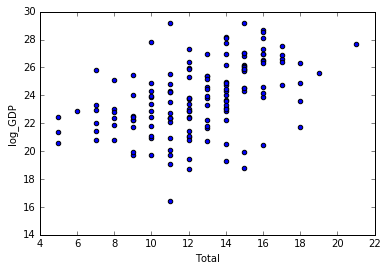

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

country_table['GDP'] = np.nan
for i in range(edu_row_num):
    find_index = country_gdp[country_gdp['country_name'] == country_table['Country or area'][i]].index
    if len(find_index) > 0:
        row_index = find_index.tolist()[0]
        country_table['GDP'][i] = country_gdp[country_table['Year'][i]][row_index]
edu_gdp = country_table[np.isfinite(country_table['GDP'])][['Country or area', 'Total', 'GDP']]
edu_gdp['log_GDP'] = np.log(edu_gdp['GDP'])
edu_gdp.plot(kind = 'scatter', x = 'Total', y = 'log_GDP')
plt.show

So this shows there is a positive coorelation total years of education and a nation's GDP. It's not a really strong coorelation.